In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from typing import Callable, List, Dict, Any

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [ ]:

import glob
import os

def load_tuning_results(results_dir="../results",  method=None):
    files = glob.glob(os.path.join(results_dir, "*.csv"))
    dfs = []
    for f in files:
        fname = os.path.basename(f).replace(".csv", "")

        parts = fname.split("_")
        file_method = parts[-1]
        algo = parts[-2]
        dataset = "_".join(parts[:-2])  
        
        if method and file_method != method:
            continue

        df = pd.read_csv(f)
        df["dataset"] = dataset
        df["algorithm"] = algo
        df["method"] = method
        if "mean_test_roc_auc" not in df.columns and "value" in df.columns:
            df["mean_test_roc_auc"] = df["value"]
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

df_randomsearch = load_tuning_results(method="randomsearch")
df_bayes = load_tuning_results(method="bayes")

df_xgb_rand = df_randomsearch[df_randomsearch.algorithm == "xgboost"]
df_cat_rand = df_randomsearch[df_randomsearch.algorithm == "catboost"]
df_lgbm_rand = df_randomsearch[df_randomsearch.algorithm == "lightgbm"]

df_xgb_bayes = df_bayes[df_bayes.algorithm == "xgboost"]
df_cat_bayes = df_bayes[df_bayes.algorithm == "catboost"]
df_lgbm_bayes = df_bayes[df_bayes.algorithm == "lightgbm"]


In [ ]:
defaults = pd.read_csv("../results_defaults/defaults_summary.csv")

defaults_xgb  = defaults[(defaults.algorithm=="xgboost")]
defaults_cat  = defaults[(defaults.algorithm=="catboost")]
defaults_lgbm = defaults[(defaults.algorithm=="lightgbm")]

In [ ]:
def find_optimal_parameters(df: pd.DataFrame, 
                          metric_column: str,
                          dataset_column: str,
                          parameter_columns: List[str],
                          g_function: Callable[[List[float]], float] = np.mean,
                          minimize: bool = True) -> Dict[str, Any]:

    grouped = df.groupby(parameter_columns).agg({
        metric_column: lambda x: g_function(list(x))
    }).reset_index()

    if minimize:
        optimal_idx = grouped[metric_column].idxmin()
    else:
        optimal_idx = grouped[metric_column].idxmax()
    
    optimal_row = grouped.loc[optimal_idx]
    
    optimal_params = optimal_row[parameter_columns].to_dict()
    
    temp_df = df.copy()
    for col, val in optimal_params.items():
        temp_df = temp_df[temp_df[col] == val]
    dataset_performances = temp_df[[dataset_column, metric_column]]
    
    result = {
        'optimal_parameters': optimal_params,
        'optimal_value': optimal_row[metric_column],
        'all_dataset_performances': dataset_performances.to_dict('records'),
        'g_function': g_function.__name__,
        'metric': metric_column
    }
    
    return result

def mean_aggregation(metrics: List[float]) -> float:
    return np.mean(metrics)

def worst_case_aggregation(metrics: List[float]) -> float:
    return np.min(metrics)

def best_case_aggregation(metrics: List[float]) -> float:
    return np.max(metrics)

def std_aggregation(metrics: List[float]) -> float:
    return np.std(metrics)

def robust_aggregation(metrics: List[float]) -> float:
    return np.mean(metrics) - np.std(metrics)


param_cols_xgb = [
    'param_model__colsample_bytree',
    'param_model__gamma', 
    'param_model__learning_rate',
    'param_model__max_depth',
    'param_model__n_estimators',
    'param_model__subsample'
]

param_cols_lgbm = [
    'param_model__learning_rate',
    'param_model__max_depth',
    'param_model__n_estimators',
    'param_model__subsample',
    'param_model__feature_fraction',
    'param_model__num_leaves'
]

param_cols_cat = [
    'param_model__learning_rate',
    'param_model__max_depth',
    'param_model__n_estimators',
    'param_model__subsample',
    'param_model__colsample_bylevel',
    'param_model__l2_leaf_reg'
]
        

In [ ]:

result_mean_cat = find_optimal_parameters(
    df=df_cat_rand,
    metric_column='mean_test_roc_auc',
    dataset_column='dataset', 
    parameter_columns=param_cols_cat,
    g_function=mean_aggregation,
    minimize=False  
)

print("\n1. Mean Aggregation:")
print(f"Optimal parameters: {result_mean_cat['optimal_parameters']}")
print(f"Average ROC AUC across datasets: {result_mean_cat['optimal_value']:.4f}")


result_worst_cat = find_optimal_parameters(
    df=df_cat_rand,
    metric_column='mean_test_roc_auc',
    dataset_column='dataset',
    parameter_columns=param_cols_cat, 
    g_function=worst_case_aggregation,
    minimize=False
)

print("\n2. Worst-case Aggregation:")
print(f"Optimal parameters: {result_worst_cat['optimal_parameters']}")
print(f"Worst-case ROC AUC: {result_worst_cat['optimal_value']:.4f}")

result_std_cat = find_optimal_parameters(
    df=df_cat_rand,
    metric_column='mean_test_roc_auc', 
    dataset_column='dataset',
    parameter_columns=param_cols_cat,
    g_function=std_aggregation,
    minimize=True 
)

print("\n3. Consistency (Std) Aggregation:")
print(f"Optimal parameters: {result_std_cat['optimal_parameters']}")
print(f"Standard deviation: {result_std_cat['optimal_value']:.4f}")


print("\n=== Comparison ===")
comparisons = [
    ("Mean", result_mean_cat),
    ("Worst-case", result_worst_cat), 
    ("Consistency", result_std_cat)
]

for name, res in comparisons:
    print(f"{name}: {res['optimal_value']:.4f}")
  
print("\n=== Performance Distribution for Mean-Optimal Parameters ===")
performances = [perf['mean_test_roc_auc'] for perf in result_mean_cat['all_dataset_performances']]
print(f"Datasets: {len(performances)}")
print(f"Performance range: {np.min(performances):.4f} - {np.max(performances):.4f}")
print(f"Mean: {np.mean(performances):.4f} ± {np.std(performances):.4f}")


1. Mean Aggregation:
Optimal parameters: {'param_model__learning_rate': 0.0372704982730818, 'param_model__max_depth': 3.0, 'param_model__n_estimators': 1176.0, 'param_model__subsample': 0.7447263801387816, 'param_model__colsample_bylevel': 0.5165253664502742, 'param_model__l2_leaf_reg': 0.489939546714915}
Average ROC AUC across datasets: 0.8758

2. Worst-case Aggregation:
Optimal parameters: {'param_model__learning_rate': 0.0047007207684461, 'param_model__max_depth': 6.0, 'param_model__n_estimators': 891.0, 'param_model__subsample': 0.6783766633467947, 'param_model__colsample_bylevel': 0.6626651653816322, 'param_model__l2_leaf_reg': 0.59890036722543}
Worst-case ROC AUC: 0.5303

3. Consistency (Std) Aggregation:
Optimal parameters: {'param_model__learning_rate': 0.0190445075498875, 'param_model__max_depth': 2.0, 'param_model__n_estimators': 101.0, 'param_model__subsample': 0.9981268498789622, 'param_model__colsample_bylevel': 0.587477463547968, 'param_model__l2_leaf_reg': 9.21163426662

In [ ]:

result_mean_xgb = find_optimal_parameters(
    df=df_xgb_rand,
    metric_column='mean_test_roc_auc',
    dataset_column='dataset', 
    parameter_columns=param_cols_xgb,
    g_function=mean_aggregation,
    minimize=False 
)

print("\n1. Mean Aggregation:")
print(f"Optimal parameters: {result_mean_xgb['optimal_parameters']}")
print(f"Average ROC AUC across datasets: {result_mean_xgb['optimal_value']:.4f}")

result_worst_xgb = find_optimal_parameters(
    df=df_xgb_rand,
    metric_column='mean_test_roc_auc',
    dataset_column='dataset',
    parameter_columns=param_cols_xgb, 
    g_function=worst_case_aggregation,
    minimize=False
)

print("\n2. Worst-case Aggregation:")
print(f"Optimal parameters: {result_worst_xgb['optimal_parameters']}")
print(f"Worst-case ROC AUC: {result_worst_xgb['optimal_value']:.4f}")

result_std_xgb = find_optimal_parameters(
    df=df_xgb_rand,
    metric_column='mean_test_roc_auc', 
    dataset_column='dataset',
    parameter_columns=param_cols_xgb,
    g_function=std_aggregation,
    minimize=True  
)

print("\n3. Consistency (Std) Aggregation:")
print(f"Optimal parameters: {result_std_xgb['optimal_parameters']}")
print(f"Standard deviation: {result_std_xgb['optimal_value']:.4f}")


print("\n=== Comparison ===")
comparisons = [
    ("Mean", result_mean_xgb),
    ("Worst-case", result_worst_xgb), 
    ("Consistency", result_std_xgb)
]

for name, res in comparisons:
    print(f"{name}: {res['optimal_value']:.4f}")
    

print("\n=== Performance Distribution for Mean-Optimal Parameters ===")
performances = [perf['mean_test_roc_auc'] for perf in result_mean_xgb['all_dataset_performances']]
print(f"Datasets: {len(performances)}")
print(f"Performance range: {np.min(performances):.4f} - {np.max(performances):.4f}")
print(f"Mean: {np.mean(performances):.4f} ± {np.std(performances):.4f}")


1. Mean Aggregation:
Optimal parameters: {'param_model__colsample_bytree': 0.7841543016677358, 'param_model__gamma': 6.967434753443191e-08, 'param_model__learning_rate': 0.0081447288663451, 'param_model__max_depth': 8.0, 'param_model__n_estimators': 1145.0, 'param_model__subsample': 0.6219948216895418}
Average ROC AUC across datasets: 0.8749

2. Worst-case Aggregation:
Optimal parameters: {'param_model__colsample_bytree': 0.8459475988463466, 'param_model__gamma': 0.0073731205649088, 'param_model__learning_rate': 0.0035937037535538, 'param_model__max_depth': 2.0, 'param_model__n_estimators': 1703.0, 'param_model__subsample': 0.6186245437484}
Worst-case ROC AUC: 0.5294

3. Consistency (Std) Aggregation:
Optimal parameters: {'param_model__colsample_bytree': 0.587477463547968, 'param_model__gamma': 6.910589404721768, 'param_model__learning_rate': 0.0190445075498875, 'param_model__max_depth': 2.0, 'param_model__n_estimators': 101.0, 'param_model__subsample': 0.9981268498789622}
Standard de

In [ ]:

result_mean_lgbm = find_optimal_parameters(
    df=df_lgbm_rand,
    metric_column='mean_test_roc_auc',
    dataset_column='dataset', 
    parameter_columns=param_cols_lgbm,
    g_function=mean_aggregation,
    minimize=False
)

print("\n1. Mean Aggregation:")
print(f"Optimal parameters: {result_mean_lgbm['optimal_parameters']}")
print(f"Average ROC AUC across datasets: {result_mean_lgbm['optimal_value']:.4f}")

result_worst_lgbm = find_optimal_parameters(
    df=df_lgbm_rand,
    metric_column='mean_test_roc_auc',
    dataset_column='dataset',
    parameter_columns=param_cols_lgbm, 
    g_function=worst_case_aggregation,
    minimize=False
)

print("\n2. Worst-case Aggregation:")
print(f"Optimal parameters: {result_worst_lgbm['optimal_parameters']}")
print(f"Worst-case ROC AUC: {result_worst_lgbm['optimal_value']:.4f}")

result_std_lgbm = find_optimal_parameters(
    df=df_lgbm_rand,
    metric_column='mean_test_roc_auc', 
    dataset_column='dataset',
    parameter_columns=param_cols_lgbm,
    g_function=std_aggregation,
    minimize=True
)

print("\n3. Consistency (Std) Aggregation:")
print(f"Optimal parameters: {result_std_lgbm['optimal_parameters']}")
print(f"Standard deviation: {result_std_lgbm['optimal_value']:.4f}")

print("\n=== Comparison ===")
comparisons = [
    ("Mean", result_mean_lgbm),
    ("Worst-case", result_worst_lgbm), 
    ("Consistency", result_std_lgbm)
]

for name, res in comparisons:
    print(f"{name}: {res['optimal_value']:.4f}")
    
print("\n=== Performance Distribution for Mean-Optimal Parameters ===")
performances = [perf['mean_test_roc_auc'] for perf in result_mean_lgbm['all_dataset_performances']]
print(f"Datasets: {len(performances)}")
print(f"Performance range: {np.min(performances):.4f} - {np.max(performances):.4f}")
print(f"Mean: {np.mean(performances):.4f} ± {np.std(performances):.4f}")



1. Mean Aggregation:
Optimal parameters: {'param_model__learning_rate': 0.0123115036324156, 'param_model__max_depth': 8.0, 'param_model__n_estimators': 1551.0, 'param_model__subsample': 0.5171942605576092, 'param_model__feature_fraction': 0.8421165132560784, 'param_model__num_leaves': 23.0}
Average ROC AUC across datasets: 0.8758

2. Worst-case Aggregation:
Optimal parameters: {'param_model__learning_rate': 0.0111896578494138, 'param_model__max_depth': 2.0, 'param_model__n_estimators': 747.0, 'param_model__subsample': 0.5070399113575422, 'param_model__feature_fraction': 0.5078182033705969, 'param_model__num_leaves': 231.0}
Worst-case ROC AUC: 0.5289

3. Consistency (Std) Aggregation:
Optimal parameters: {'param_model__learning_rate': 0.0370962416561073, 'param_model__max_depth': 2.0, 'param_model__n_estimators': 1324.0, 'param_model__subsample': 0.7540993883703593, 'param_model__feature_fraction': 0.8161529152967897, 'param_model__num_leaves': 139.0}
Standard deviation: 0.1685

=== Co

In [ ]:
comparison_data = {
    'XGBoost_Mean': result_mean_xgb['optimal_parameters'],
    'XGBoost_WorstCase': result_worst_xgb['optimal_parameters'],
    'XGBoost_Std': result_std_xgb['optimal_parameters'],
    'CatBoost_Mean': result_mean_cat['optimal_parameters'],
    'CatBoost_WorstCase': result_worst_cat['optimal_parameters'],
    'CatBoost_Std': result_std_cat['optimal_parameters'],
    'LightGBM_Mean': result_mean_lgbm['optimal_parameters'],
    'LightGBM_WorstCase': result_worst_lgbm['optimal_parameters'],
    'LightGBM_Std': result_std_lgbm['optimal_parameters']
}
print("Optimal Parameters Comparison:")

desired_order = [
    'XGBoost_Mean', 'XGBoost_Std', 'XGBoost_WorstCase',
    'CatBoost_Mean', 'CatBoost_Std', 'CatBoost_WorstCase', 
    'LightGBM_Mean', 'LightGBM_Std', 'LightGBM_WorstCase'
]

df_comparison = pd.DataFrame(comparison_data)
df_comparison = df_comparison[desired_order]
df_comparison


Optimal Parameters Comparison:


,XGBoost_Mean,XGBoost_Std,XGBoost_WorstCase,CatBoost_Mean,CatBoost_Std,CatBoost_WorstCase,LightGBM_Mean,LightGBM_Std,LightGBM_WorstCase
param_model__colsample_bytree,7.841543e-01,0.587477,0.845948,NaN,NaN,NaN,NaN,NaN,NaN
param_model__gamma,6.967435e-08,6.910589,0.007373,NaN,NaN,NaN,NaN,NaN,NaN
param_model__learning_rate,8.144729e-03,0.019045,0.003594,0.037270,0.019045,0.004701,0.012312,0.037096,0.011190
param_model__max_depth,8.000000e+00,2.000000,2.000000,3.000000,2.000000,6.000000,8.000000,2.000000,2.000000
param_model__n_estimators,1.145000e+03,101.000000,1703.000000,1176.000000,101.000000,891.000000,1551.000000,1324.000000,747.000000
param_model__subsample,6.219948e-01,0.998127,0.618625,0.744726,0.998127,0.678377,0.517194,0.754099,0.507040
param_model__colsample_bylevel,NaN,NaN,NaN,0.516525,0.587477,0.662665,NaN,NaN,NaN
param_model__l2_leaf_reg,NaN,NaN,NaN,0.489940,9.211634,0.598900,NaN,NaN,NaN
param_model__feature_fraction,NaN,NaN,NaN,NaN,NaN,NaN,0.842117,0.816153,0.507818
param_model__num_leaves,NaN,NaN,NaN,NaN,NaN,NaN,23.000000,139.000000,231.000000


In [ ]:
def analyze_performance_differences(df: pd.DataFrame,
                                  optimal_params: Dict,
                                  metric_column: str,
                                  dataset_column: str,
                                  parameter_columns: List[str]) -> pd.DataFrame:
    temp_df = df.copy()
    for col, val in optimal_params.items():
        temp_df = temp_df[temp_df[col] == val]
        
    optimal_performances = temp_df[[dataset_column, metric_column]]
    
    optimal_performances = optimal_performances.rename(
        columns={metric_column: 'optimal_performance'}
    )
    
    df_with_optimal = df.merge(
        optimal_performances, 
        on=dataset_column, 
        how='left'
    )
    
    df_with_optimal['performance_diff'] = (
        df_with_optimal[metric_column] - df_with_optimal['optimal_performance']
    )
    
    is_optimal_mask = True
    for col, val in optimal_params.items():
        is_optimal_mask &= (df_with_optimal[col] == val)

    df_with_optimal['is_optimal'] = is_optimal_mask
    
    return df_with_optimal

def create_performance_difference_boxplots(df_with_diffs: pd.DataFrame,
                                         dataset_column: str,
                                         metric_name: str = "ROC AUC"):
    df_non_optimal = df_with_diffs[~df_with_diffs['is_optimal']].copy()
    
    plt.style.use('default')
    sns.set_palette("husl")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    sns.boxplot(data=df_non_optimal, x=dataset_column, y='performance_diff', ax=ax1)
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Wydajność optymalna')
    ax1.set_title(f'Rozkład różnic wydajności względem konfiguracji optymalnej\n({metric_name})', 
                  fontsize=14, fontweight='bold')
    ax1.set_ylabel(f'Różnica {metric_name}', fontsize=12)
    ax1.set_xlabel('Dataset', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    df_non_optimal['performance_diff_pct'] = (
        df_non_optimal['performance_diff'] / df_non_optimal['optimal_performance'] * 100
    )
    
    sns.boxplot(data=df_non_optimal, x=dataset_column, y='performance_diff_pct', ax=ax2)
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Wydajność optymalna')
    ax2.set_title(f'Rozkład procentowych różnic wydajności względem konfiguracji optymalnej\n({metric_name})', 
                  fontsize=14, fontweight='bold')
    ax2.set_ylabel(f'Różnica {metric_name} [%]', fontsize=12)
    ax2.set_xlabel('Dataset', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return df_non_optimal

def create_summary_statistics(df_with_diffs: pd.DataFrame, dataset_column: str):
    df_non_optimal = df_with_diffs[~df_with_diffs['is_optimal']].copy()
    
    stats = df_non_optimal.groupby(dataset_column)['performance_diff'].agg([
        'count', 'mean', 'std', 'min', 'max',
        lambda x: np.percentile(x, 25),
        lambda x: np.percentile(x, 50),
        lambda x: np.percentile(x, 75)
    ]).round(4)
    
    stats.columns = ['count', 'mean', 'std', 'min', 'max', 'Q1', 'median', 'Q3']
    
    df_non_optimal['performance_diff_pct'] = (
        df_non_optimal['performance_diff'] / df_non_optimal['optimal_performance'] * 100
    )
    
    stats_pct = df_non_optimal.groupby(dataset_column)['performance_diff_pct'].agg([
        'mean', 'std', 'min', 'max'
    ]).round(2)
    
    stats_pct.columns = [f'{col}_pct' for col in stats_pct.columns]
    
    stats_combined = pd.concat([stats, stats_pct], axis=1)
    
    return stats_combined

def create_combined_boxplot(df_with_diffs: pd.DataFrame, metric_name: str = "ROC AUC"):

    df_non_optimal = df_with_diffs[~df_with_diffs['is_optimal']].copy()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    sns.boxplot(data=df_non_optimal, y='performance_diff', ax=ax1)
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    ax1.set_title(f'Rozkład wszystkich różnic wydajności\n({metric_name})', fontsize=14)
    ax1.set_ylabel(f'Różnica {metric_name}')
    ax1.grid(True, alpha=0.3)
    
    df_non_optimal['performance_diff_pct'] = (
        df_non_optimal['performance_diff'] / df_non_optimal['optimal_performance'] * 100
    )
    
    sns.boxplot(data=df_non_optimal, y='performance_diff_pct', ax=ax2)
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    ax2.set_title(f'Rozkład wszystkich procentowych różnic wydajności\n({metric_name})', fontsize=14)
    ax2.set_ylabel(f'Różnica {metric_name} [%]')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


Optymalne parametry:
  param_model__colsample_bytree: 0.7841543016677358
  param_model__gamma: 6.967434753443191e-08
  param_model__learning_rate: 0.0081447288663451
  param_model__max_depth: 8.0
  param_model__n_estimators: 1145.0
  param_model__subsample: 0.6219948216895418

Tworzenie boxplotów... :) XGBoost


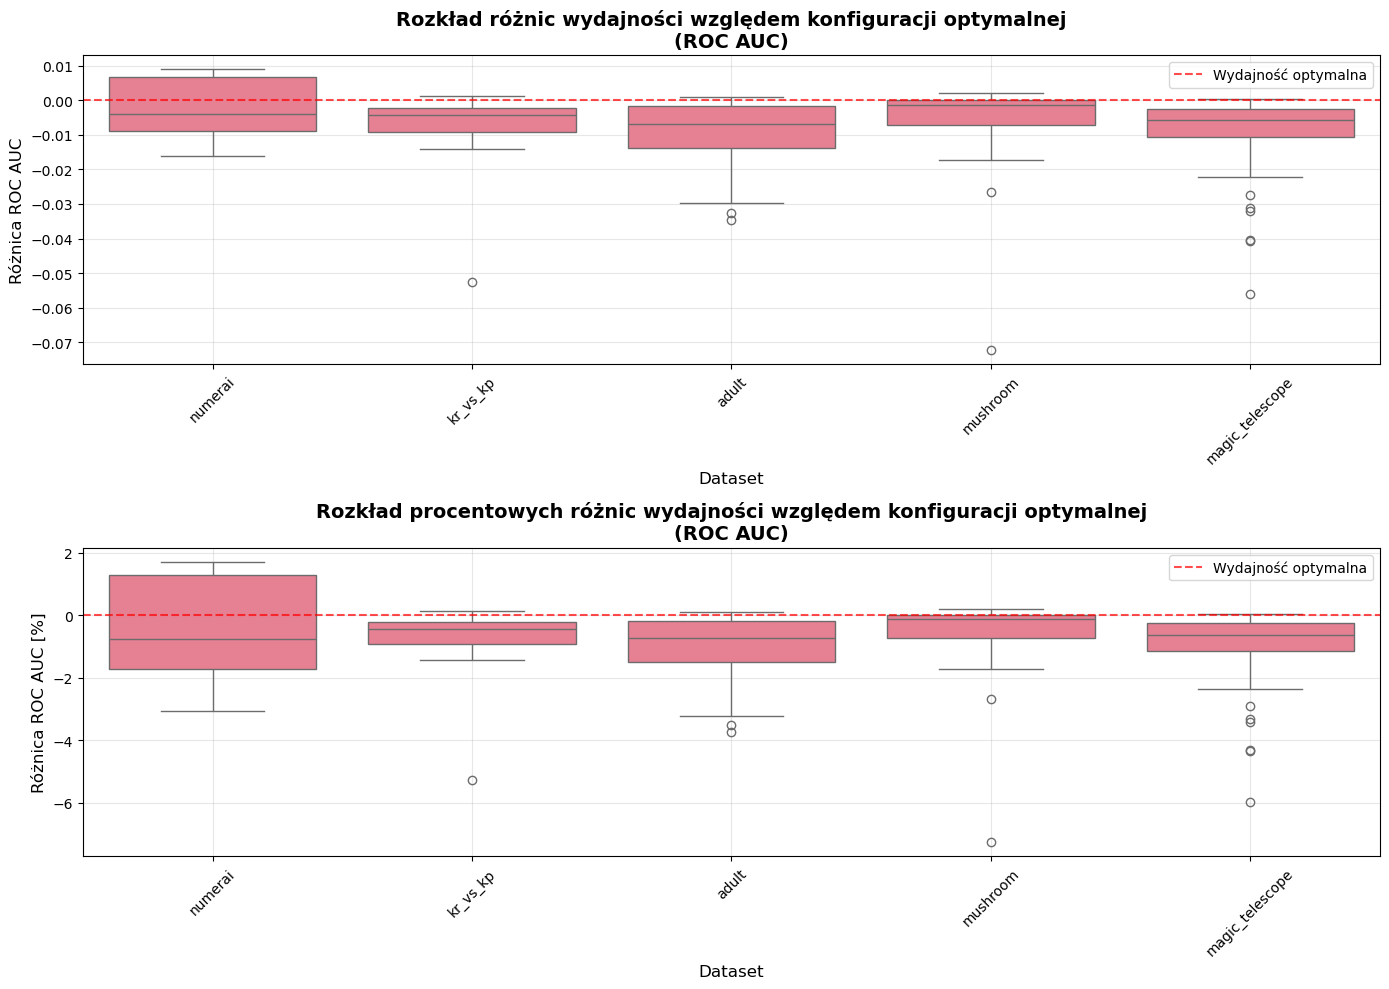


Zbiorczy boxplot wszystkich różnic... :) XGBoost


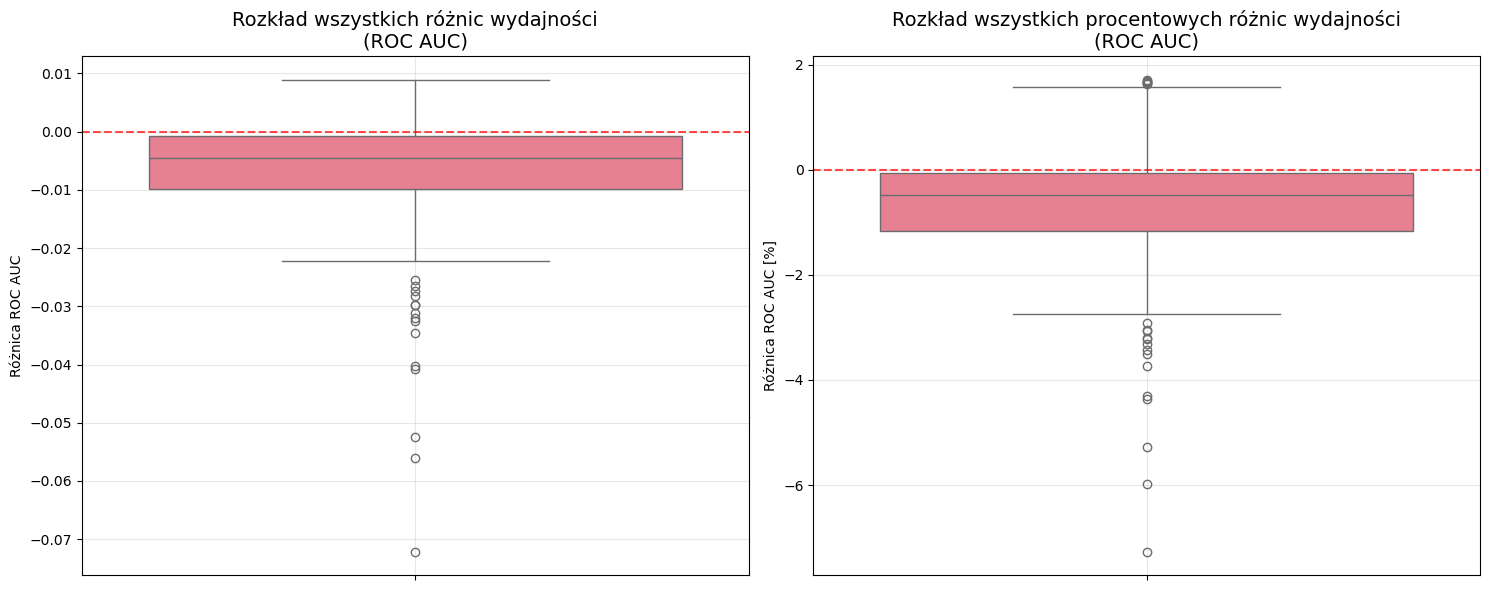


Statystyki różnic wydajności:
                 count    mean     std     min     max      Q1  median  \
dataset                                                                  
adult               49 -0.0098  0.0097 -0.0346  0.0009 -0.0139 -0.0068   
kr_vs_kp            49 -0.0062  0.0079 -0.0525  0.0013 -0.0092 -0.0044   
magic_telescope     49 -0.0097  0.0121 -0.0560  0.0003 -0.0107 -0.0058   
mushroom            49 -0.0053  0.0115 -0.0721  0.0021 -0.0072 -0.0013   
numerai             49 -0.0018  0.0080 -0.0160  0.0089 -0.0089 -0.0039   

                     Q3  mean_pct  std_pct  min_pct  max_pct  
dataset                                                       
adult           -0.0016     -1.06     1.04    -3.73     0.10  
kr_vs_kp        -0.0022     -0.62     0.80    -5.27     0.13  
magic_telescope -0.0025     -1.04     1.29    -5.98     0.03  
mushroom        -0.0000     -0.54     1.16    -7.26     0.21  
numerai          0.0067     -0.34     1.53    -3.08     1.71  


In [ ]:
result_xgb = find_optimal_parameters(
    df=df_xgb_rand,
    metric_column='mean_test_roc_auc',
    dataset_column='dataset',
    parameter_columns=param_cols_xgb,
    g_function=np.mean,
    minimize=False
)

optimal_params = result_xgb['optimal_parameters']

print("Optymalne parametry:")
for param, value in optimal_params.items():
    print(f"  {param}: {value}")

df_with_differences_xgb = analyze_performance_differences(
    df=df_xgb_rand,
    optimal_params=optimal_params,
    metric_column='mean_test_roc_auc',
    dataset_column='dataset',
    parameter_columns=param_cols_xgb
)

print("\nTworzenie boxplotów... :) XGBoost")
df_non_optimal = create_performance_difference_boxplots(
    df_with_diffs=df_with_differences_xgb,
    dataset_column='dataset',
    metric_name="ROC AUC"
)

print("\nZbiorczy boxplot wszystkich różnic... :) XGBoost")
create_combined_boxplot(df_with_differences_xgb, metric_name="ROC AUC")

print("\nStatystyki różnic wydajności:")
stats_summary = create_summary_statistics(df_with_differences_xgb, 'dataset')
print(stats_summary)

better_configs = df_with_differences_xgb[
    (df_with_differences_xgb['performance_diff'] > 0) & 
    (~df_with_differences_xgb['is_optimal'])
]


Interpretacja

Wartości > 0 oznaczają, że dla danego datasetu istnieją konfiguracje lepsze niż ten "globalny zwycięzca".

Wartości < 0 oznaczają, że inne badane konfiguracje były gorsze od "globalnego zwycięzcy".

Wnioski:

Dla zbioru numerai: Dla tego zbioru na wykresie duza czesc box plotu jest wyzej zera. Oznacza to, że użycie domyślnych lub wyznaczonych w naszym przypadku eksperymentalnie ustawień XGBoosta spowoduje utratę wydajności. Aby uzyskać dobry wynik na tym zbiorze nalezy dostroić hiperparametry specyficznie pod ten zbiór, ignorując to, co działa na innych.

Dla zbiorów kr_vs_kp, adult, mushroom i magic_telescope: Wykresy box plot znajduja sie ponizej linii zero. Konfiguracja "globalnie optymalna" jest dla nich albo najlepsza, albo bardzo bliska najlepszej.

Optymalne parametry:
  param_model__learning_rate: 0.0372704982730818
  param_model__max_depth: 3.0
  param_model__n_estimators: 1176.0
  param_model__subsample: 0.7447263801387816
  param_model__colsample_bylevel: 0.5165253664502742
  param_model__l2_leaf_reg: 0.489939546714915

Tworzenie boxplotów... :) CatBoost


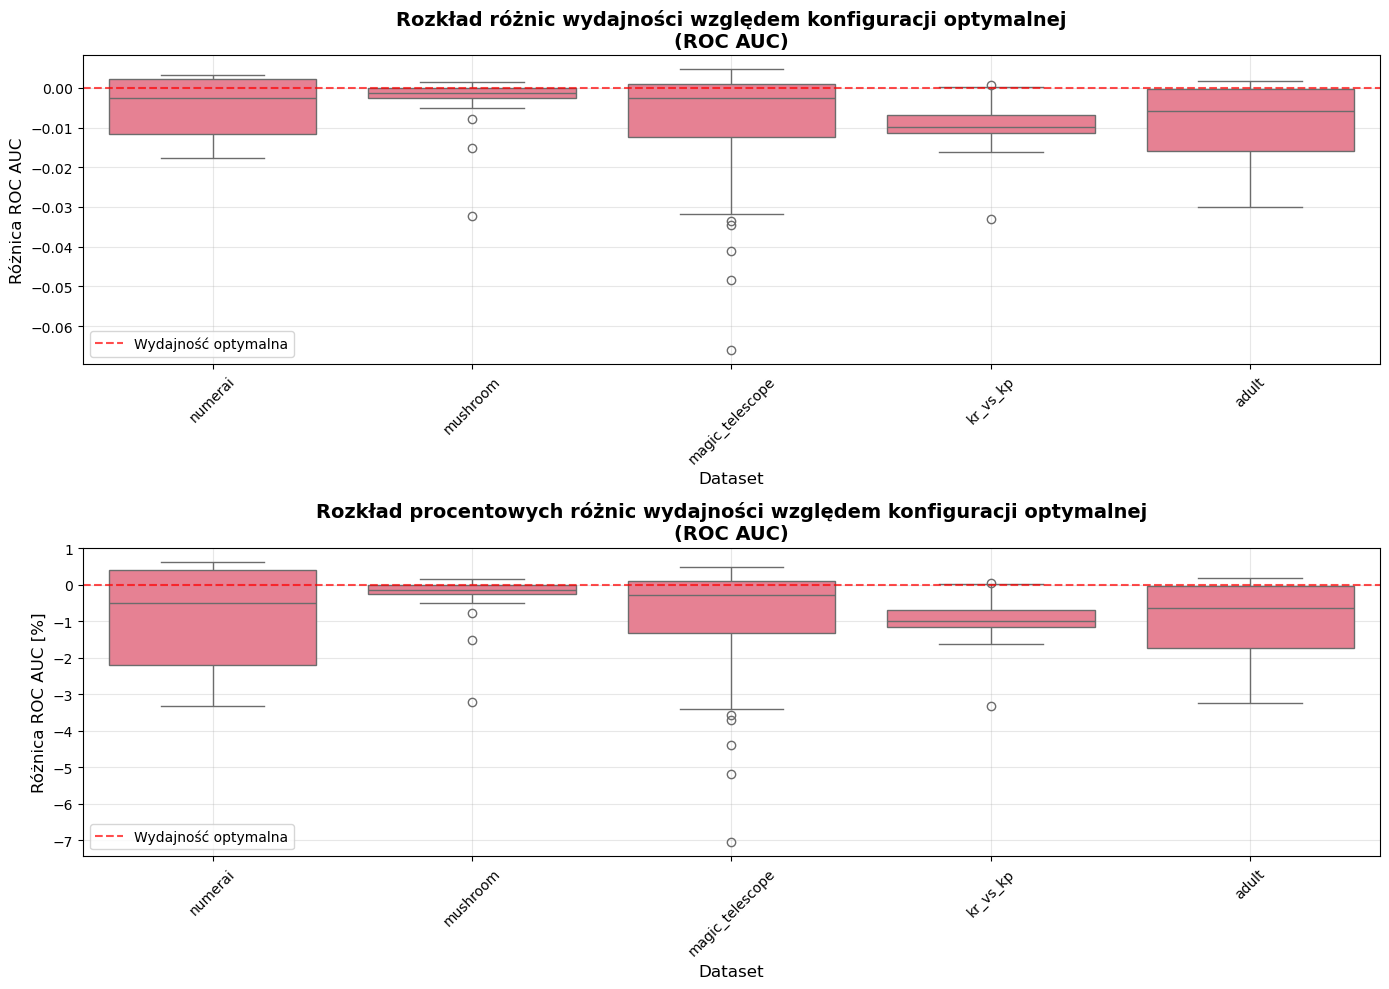


Zbiorczy boxplot wszystkich różnic... :) CatBoost


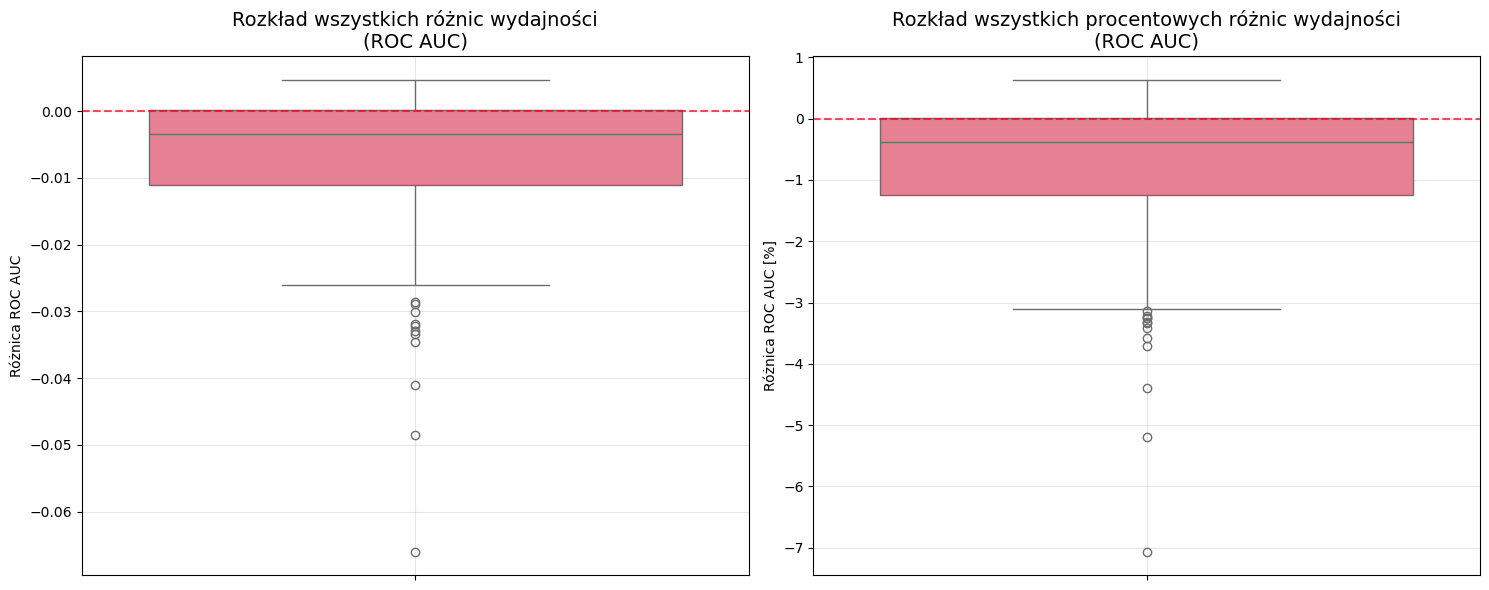


Statystyki różnic wydajności:
                 count    mean     std     min     max      Q1  median  \
dataset                                                                  
adult               49 -0.0081  0.0086 -0.0301  0.0018 -0.0160 -0.0058   
kr_vs_kp            49 -0.0093  0.0054 -0.0330  0.0007 -0.0114 -0.0098   
magic_telescope     49 -0.0087  0.0156 -0.0660  0.0047 -0.0123 -0.0025   
mushroom            49 -0.0022  0.0052 -0.0322  0.0016 -0.0026 -0.0013   
numerai             49 -0.0050  0.0074 -0.0176  0.0033 -0.0116 -0.0026   

                     Q3  mean_pct  std_pct  min_pct  max_pct  
dataset                                                       
adult           -0.0002     -0.88     0.93    -3.25     0.19  
kr_vs_kp        -0.0067     -0.94     0.54    -3.32     0.07  
magic_telescope  0.0010     -0.93     1.67    -7.06     0.50  
mushroom         0.0001     -0.22     0.52    -3.22     0.16  
numerai          0.0022     -0.94     1.41    -3.33     0.63  


In [ ]:
result_cat = find_optimal_parameters(
    df=df_cat_rand,
    metric_column='mean_test_roc_auc',
    dataset_column='dataset',
    parameter_columns=param_cols_cat,
    g_function=np.mean,
    minimize=False
)

optimal_params = result_cat['optimal_parameters']

print("Optymalne parametry:")
for param, value in optimal_params.items():
    print(f"  {param}: {value}")

df_with_differences_cat = analyze_performance_differences(
    df=df_cat_rand,
    optimal_params=optimal_params,
    metric_column='mean_test_roc_auc',
    dataset_column='dataset',
    parameter_columns=param_cols_cat
)

print("\nTworzenie boxplotów... :) CatBoost")
df_non_optimal = create_performance_difference_boxplots(
    df_with_diffs=df_with_differences_cat,
    dataset_column='dataset',
    metric_name="ROC AUC"
)

print("\nZbiorczy boxplot wszystkich różnic... :) CatBoost")
create_combined_boxplot(df_with_differences_cat, metric_name="ROC AUC")

print("\nStatystyki różnic wydajności:")
stats_summary = create_summary_statistics(df_with_differences_cat, 'dataset')
print(stats_summary)

better_configs = df_with_differences_cat[
    (df_with_differences_cat['performance_diff'] > 0) & 
    (~df_with_differences_cat['is_optimal'])
]


CatBoost jest tunowalny, bo mozna wyciagnac podobne wnioski. Sa outliery (do -0.07 AUC), box-plot-y sa pod linia zera. Ale jego optymalna konfiguracja jest lepsza i bardziej stabilna niż w przypadku XGBoost, mozna stwierdzic patrzac na numerai dataset.

Optymalne parametry:
  param_model__learning_rate: 0.0123115036324156
  param_model__max_depth: 8.0
  param_model__n_estimators: 1551.0
  param_model__subsample: 0.5171942605576092
  param_model__feature_fraction: 0.8421165132560784
  param_model__num_leaves: 23.0

Tworzenie boxplotów... :) LightGBM


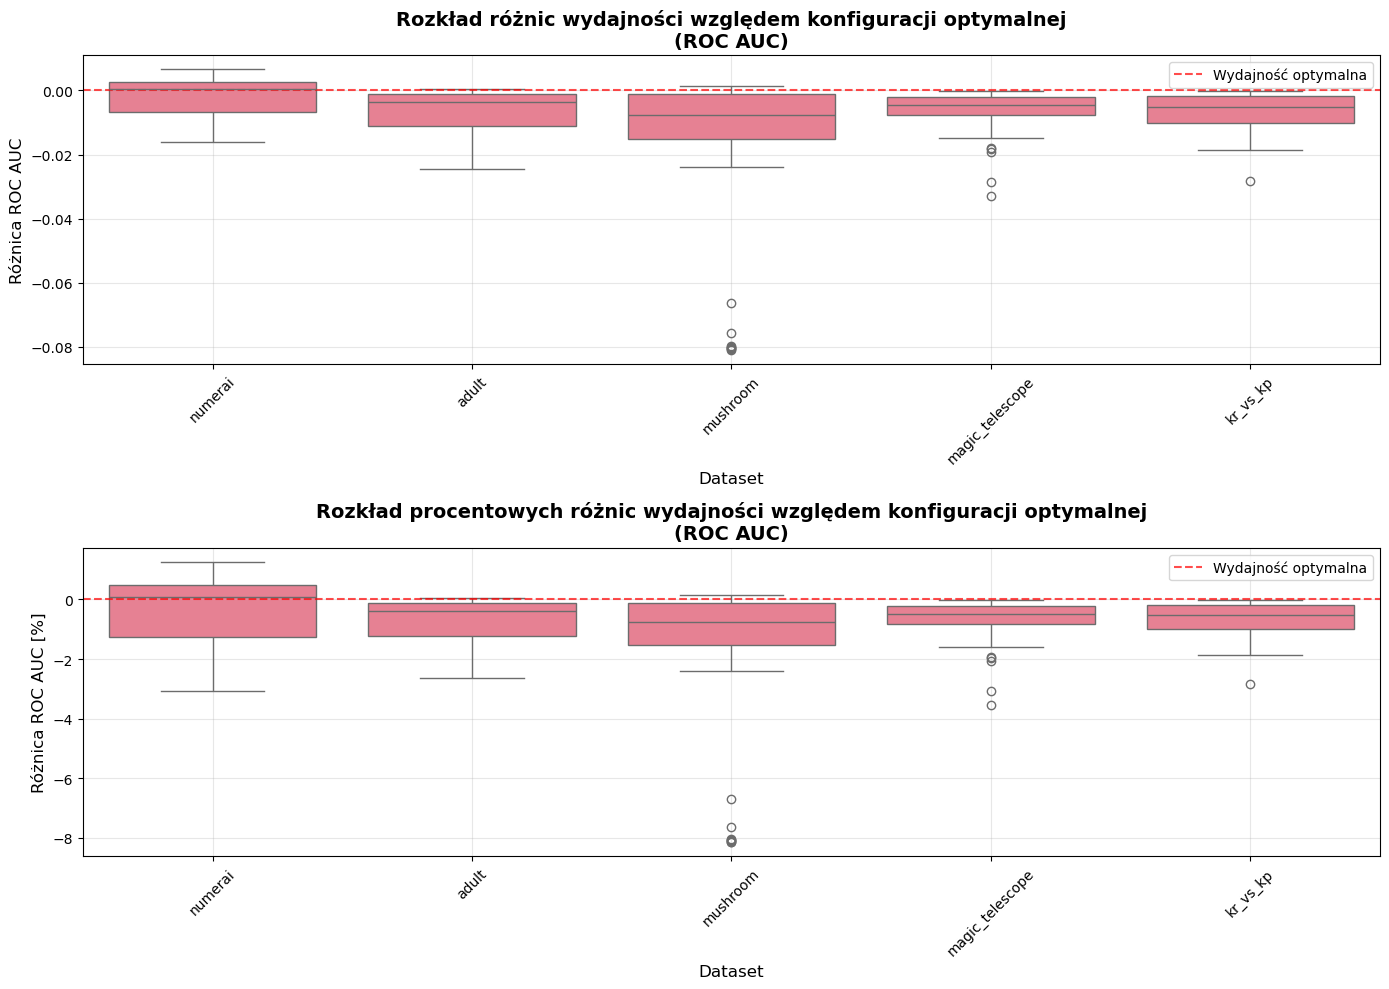


Zbiorczy boxplot wszystkich różnic... :) LightGBM


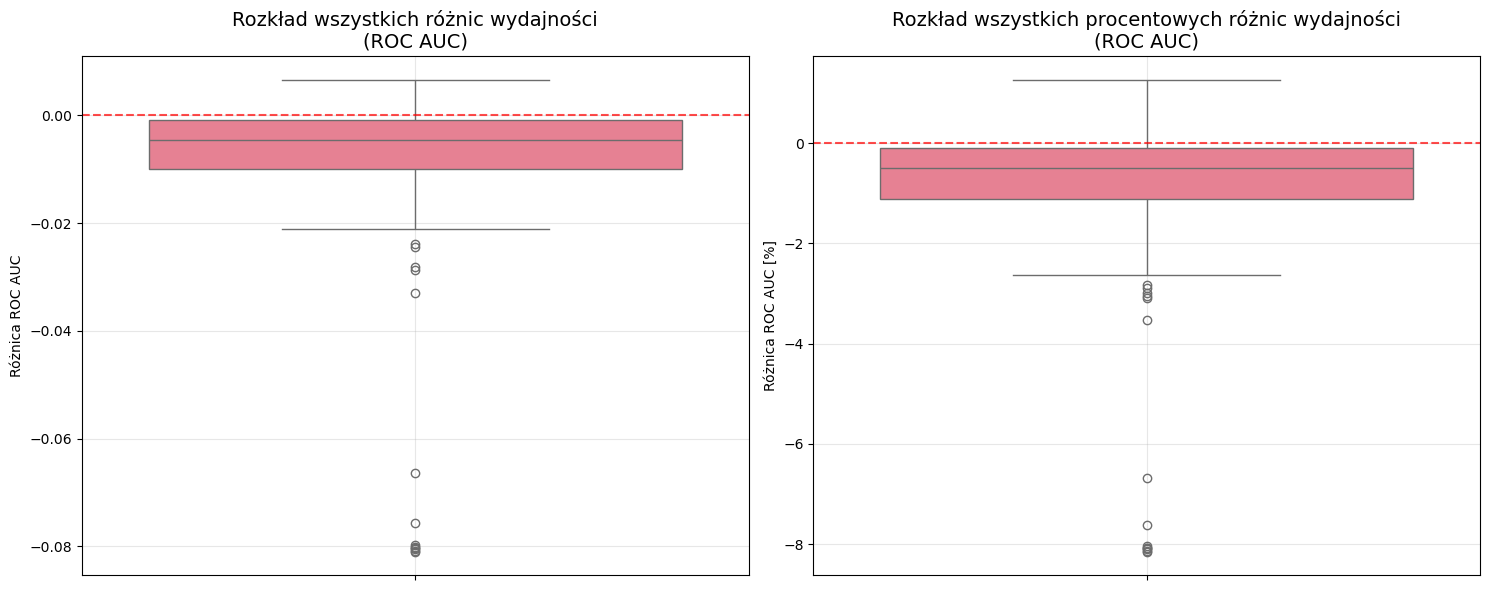


Statystyki różnic wydajności:
                 count    mean     std     min     max      Q1  median  \
dataset                                                                  
adult               49 -0.0065  0.0067 -0.0245  0.0004 -0.0112 -0.0035   
kr_vs_kp            49 -0.0064  0.0057 -0.0282 -0.0002 -0.0100 -0.0051   
magic_telescope     49 -0.0066  0.0070 -0.0330 -0.0000 -0.0076 -0.0046   
mushroom            49 -0.0183  0.0274 -0.0810  0.0014 -0.0152 -0.0076   
numerai             49 -0.0020  0.0064 -0.0161  0.0066 -0.0066  0.0005   

                     Q3  mean_pct  std_pct  min_pct  max_pct  
dataset                                                       
adult           -0.0010     -0.70     0.73    -2.63     0.04  
kr_vs_kp        -0.0017     -0.64     0.57    -2.82    -0.02  
magic_telescope -0.0020     -0.70     0.74    -3.52    -0.00  
mushroom        -0.0011     -1.84     2.75    -8.15     0.14  
numerai          0.0026     -0.38     1.22    -3.09     1.26  


In [ ]:
result_lgbm = find_optimal_parameters(
    df=df_lgbm_rand,
    metric_column='mean_test_roc_auc',
    dataset_column='dataset',
    parameter_columns=param_cols_lgbm,
    g_function=np.mean,
    minimize=False
)

optimal_params = result_lgbm['optimal_parameters']

print("Optymalne parametry:")
for param, value in optimal_params.items():
    print(f"  {param}: {value}")

df_with_differences_lgbm = analyze_performance_differences(
    df=df_lgbm_rand,
    optimal_params=optimal_params,
    metric_column='mean_test_roc_auc',
    dataset_column='dataset',
    parameter_columns=param_cols_lgbm
)

print("\nTworzenie boxplotów... :) LightGBM")
df_non_optimal = create_performance_difference_boxplots(
    df_with_diffs=df_with_differences_lgbm,
    dataset_column='dataset',
    metric_name="ROC AUC"
)

print("\nZbiorczy boxplot wszystkich różnic... :) LightGBM")
create_combined_boxplot(df_with_differences_lgbm, metric_name="ROC AUC")

print("\nStatystyki różnic wydajności:")
stats_summary = create_summary_statistics(df_with_differences_lgbm, 'dataset')
print(stats_summary)

better_configs = df_with_differences_lgbm[
    (df_with_differences_lgbm['performance_diff'] > 0) & 
    (~df_with_differences_lgbm['is_optimal'])
]


In [ ]:
res_xgb = find_optimal_parameters(df_xgb_rand, 'mean_test_roc_auc', 'dataset', param_cols_xgb, np.mean, False)
df_diff_xgb = analyze_performance_differences(
    df_xgb_rand, res_xgb['optimal_parameters'], 'mean_test_roc_auc', 'dataset', param_cols_xgb
)

res_cat = find_optimal_parameters(df_cat_rand, 'mean_test_roc_auc', 'dataset', param_cols_cat, np.mean, False)
df_diff_cat = analyze_performance_differences(
    df_cat_rand, res_cat['optimal_parameters'], 'mean_test_roc_auc', 'dataset', param_cols_cat
)

res_lgbm = find_optimal_parameters(df_lgbm_rand, 'mean_test_roc_auc', 'dataset', param_cols_lgbm, np.mean, False)
df_diff_lgbm = analyze_performance_differences(
    df_lgbm_rand, res_lgbm['optimal_parameters'], 'mean_test_roc_auc', 'dataset', param_cols_lgbm
)

df_diff_xgb['algorithm'] = 'XGBoost'
df_diff_cat['algorithm'] = 'CatBoost'
df_diff_lgbm['algorithm'] = 'LightGBM'

df_all_algos = pd.concat([df_diff_xgb, df_diff_cat, df_diff_lgbm])

df_plot_data = df_all_algos[~df_all_algos['is_optimal']].copy()

df_plot_data['performance_diff_pct'] = (
    df_plot_data['performance_diff'] / df_plot_data['optimal_performance'] * 100
)


In [32]:
df_plot_data.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__colsample_bytree,param_model__gamma,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__subsample,...,algorithm,method,param_model__colsample_bylevel,param_model__l2_leaf_reg,param_model__feature_fraction,param_model__num_leaves,optimal_performance,performance_diff,is_optimal,performance_diff_pct
0,15.480540,0.270260,1.259341,0.025937,0.687270,3.601047e+00,0.065049,6,1738,0.722916,...,XGBoost,randomsearch,NaN,NaN,NaN,NaN,0.520537,-0.003913,False,-0.751726
1,81.913868,0.835193,11.998542,0.343477,0.549987,1.359064e-04,0.006709,9,1787,0.825444,...,XGBoost,randomsearch,NaN,NaN,NaN,NaN,0.520537,-0.001464,False,-0.281183
2,11.443784,0.331508,1.405797,0.052054,0.528206,3.147668e-02,0.211305,3,1315,0.996106,...,XGBoost,randomsearch,NaN,NaN,NaN,NaN,0.520537,-0.008270,False,-1.588835
3,142.163957,2.425654,15.422571,0.285944,0.808741,3.198000e-03,0.001041,10,1684,0.762387,...,XGBoost,randomsearch,NaN,NaN,NaN,NaN,0.520537,0.006010,False,1.154500
4,23.229678,0.246174,3.557359,0.030696,0.699930,2.630213e-08,0.258292,4,1999,0.757117,...,XGBoost,randomsearch,NaN,NaN,NaN,NaN,0.520537,-0.016020,False,-3.077558


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def create_grouped_boxplots_annotated(df_plot: pd.DataFrame,
                                      dataset_column: str,
                                      algorithm_column: str,
                                      y_column: str,
                                      title: str,
                                      y_label: str,
                                      save_path: str = "../tunability_plots/combined_performance_differences_boxplot.png"):
    
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(16, 9))
    sns.set_palette("colorblind") 

    dataset_order = sorted(df_plot[dataset_column].unique())
    algorithm_order = sorted(df_plot[algorithm_column].unique())

    ax = sns.boxplot(data=df_plot, 
                     x=dataset_column, 
                     y=y_column, 
                     hue=algorithm_column,
                     order=dataset_order,
                     hue_order=algorithm_order)  

    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.8, label='Wydajność optymalna')

    num_categories = len(dataset_order)
    num_hues = len(algorithm_order)
    width = 0.8
    
    bar_width = width / num_hues 
    
    for i, dataset in enumerate(dataset_order):
        for j, algo in enumerate(algorithm_order):
            
            subset = df_plot[(df_plot[dataset_column] == dataset) & 
                             (df_plot[algorithm_column] == algo)]
            
            if not subset.empty:
                max_val = subset[y_column].max()
                
                x_pos = i - (width / 2) + (bar_width / 2) + (j * bar_width)
                
                if max_val > 0:
                    color = 'green'
                    weight = 'bold'
                    text_val = f"+{max_val:.3f}"
                else:
                    color = 'black'
                    weight = 'normal'
                    text_val = f"{max_val:.3f}"

                ax.text(x_pos, 
                        max_val + (max_val * 0.02) + 0.002,
                        text_val, 
                        ha='center', 
                        va='bottom', 
                        fontsize=9, 
                        color=color,
                        fontweight=weight,
                        rotation=90)

    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.ylabel(y_label, fontsize=12)
    plt.xlabel('Dataset', fontsize=12)
    plt.xticks(rotation=45, ha='right') 
    
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    if 'Wydajność optymalna' in by_label:
        opt_handle = by_label.pop('Wydajność optymalna')
        by_label['Wydajność optymalna'] = opt_handle
        
    plt.legend(by_label.values(), by_label.keys(), title=algorithm_column.capitalize())

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight') 
    
    plt.show()


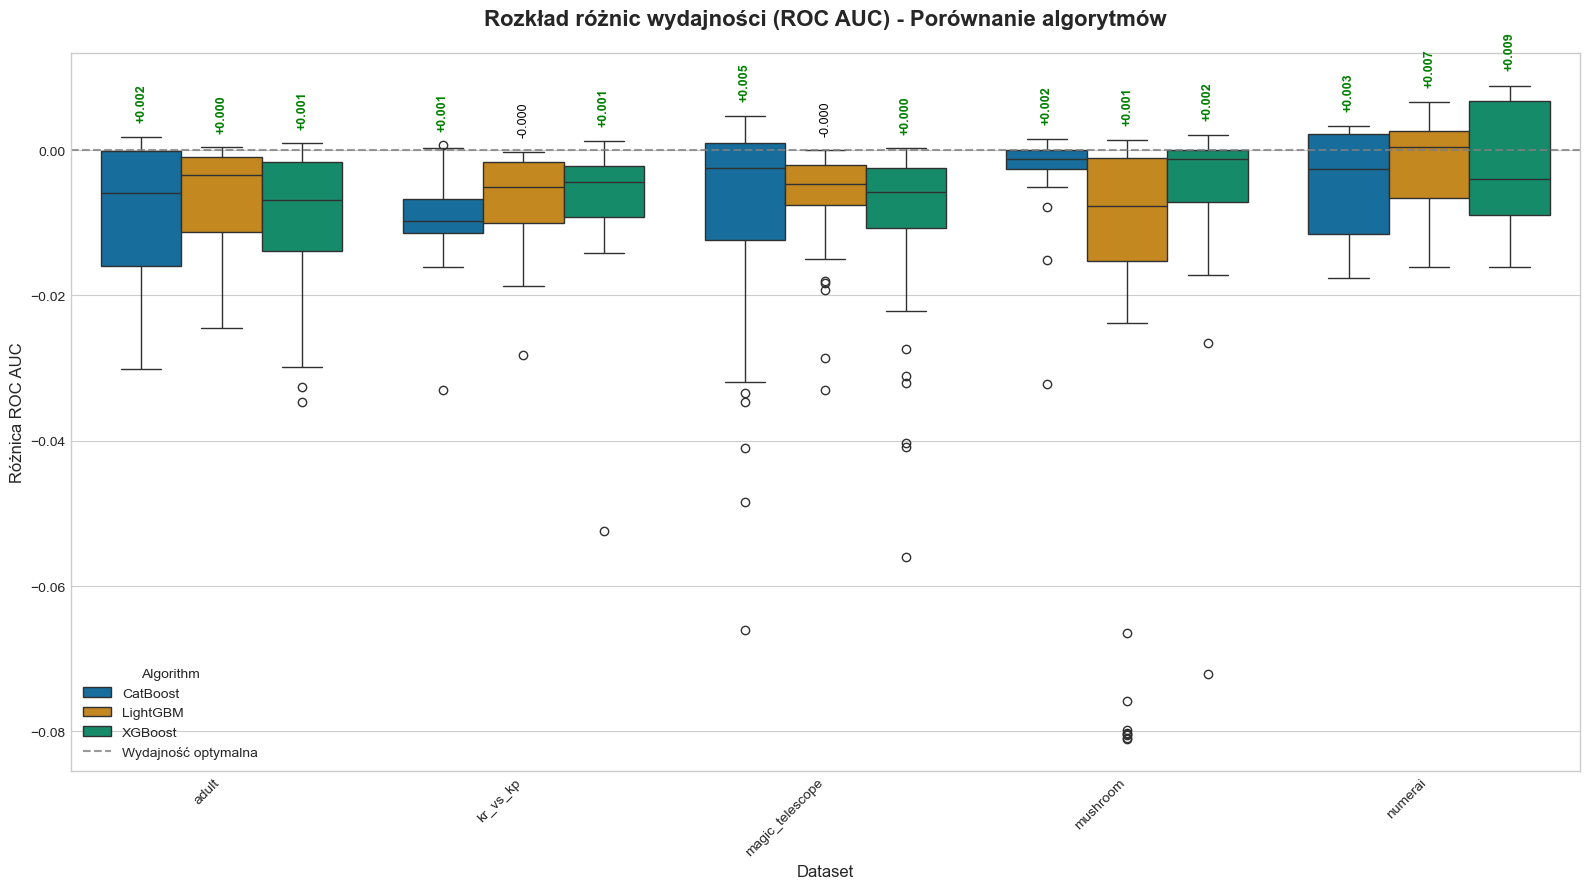

In [ ]:
create_grouped_boxplots_annotated(
    df_plot=df_plot_data,
    dataset_column='dataset',
    algorithm_column='algorithm',
    y_column='performance_diff',
    title='Rozkład różnic wydajności (ROC AUC) - Porównanie algorytmów',
    y_label=f'Różnica ROC AUC'
)


In [25]:
df_xgb_bayes.head()

,number,value,param_model__colsample_bytree,param_model__gamma,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__subsample,state,dataset,algorithm,method,mean_test_roc_auc,param_model__feature_fraction,param_model__num_leaves,param_model__colsample_bylevel,param_model__l2_leaf_reg
0,0,0.921672,0.659361,1.804514e+00,0.002357,6,618,0.800561,COMPLETE,magic_telescope,xgboost,bayes,0.921672,NaN,NaN,NaN,NaN
1,1,0.927713,0.590040,5.985163e-08,0.008067,4,1037,0.778863,COMPLETE,magic_telescope,xgboost,bayes,0.927713,NaN,NaN,NaN,NaN
2,2,0.938508,0.679557,7.765680e-06,0.005138,11,1490,0.764186,COMPLETE,magic_telescope,xgboost,bayes,0.938508,NaN,NaN,NaN,NaN
3,3,0.936531,0.919835,3.407369e-01,0.024449,11,239,0.793532,COMPLETE,magic_telescope,xgboost,bayes,0.936531,NaN,NaN,NaN,NaN
4,4,0.932625,0.795485,2.246913e-04,0.228661,11,956,0.885429,COMPLETE,magic_telescope,xgboost,bayes,0.932625,NaN,NaN,NaN,NaN


In [23]:
res_xgb['optimal_parameters']

{'param_model__colsample_bytree': 0.7841543016677358,
 'param_model__gamma': 6.967434753443191e-08,
 'param_model__learning_rate': 0.0081447288663451,
 'param_model__max_depth': 8.0,
 'param_model__n_estimators': 1145.0,
 'param_model__subsample': 0.6219948216895418}

In [ ]:
df_cat_bayes.columns = [col.replace('user_attrs_', 'param_model__', 1) 
                        if col.startswith('user_attrs_') else col 
                        for col in df_cat_bayes.columns]
df_xgb_bayes.columns = [col.replace('user_attrs_', 'param_model__', 1) 
                        if col.startswith('user_attrs_') else col 
                        for col in df_xgb_bayes.columns]
df_lgbm_bayes.columns = [col.replace('user_attrs_', 'param_model__', 1) 
                        if col.startswith('user_attrs_') else col 
                        for col in df_lgbm_bayes.columns]

res_xgb = find_optimal_parameters(df_xgb_rand, 'mean_test_roc_auc', 'dataset', param_cols_xgb, np.mean, False)

optimal_perf_dict_xgb = df_with_differences_xgb[['dataset', 'optimal_performance']] \
    .drop_duplicates() \
    .set_index('dataset')['optimal_performance'] \
    .to_dict()

df_with_optimal_bayes_xgb = df_xgb_bayes.copy()
df_with_optimal_bayes_xgb['optimal_performance'] = df_with_optimal_bayes_xgb['dataset'].map(optimal_perf_dict_xgb)

df_with_optimal_bayes_xgb['performance_diff'] = (
    df_with_optimal_bayes_xgb['mean_test_roc_auc'] - df_with_optimal_bayes_xgb['optimal_performance']
)

res_cat = find_optimal_parameters(df_cat_rand, 'mean_test_roc_auc', 'dataset', param_cols_cat, np.mean, False)

optimal_perf_dict_cat = df_with_differences_cat[['dataset', 'optimal_performance']] \
    .drop_duplicates() \
    .set_index('dataset')['optimal_performance'] \
    .to_dict()

df_with_optimal_bayes_cat = df_cat_bayes.copy()
df_with_optimal_bayes_cat['optimal_performance'] = df_with_optimal_bayes_cat['dataset'].map(optimal_perf_dict_cat)

df_with_optimal_bayes_cat['performance_diff'] = (
    df_with_optimal_bayes_cat['mean_test_roc_auc'] - df_with_optimal_bayes_cat['optimal_performance']
)

res_lgbm = find_optimal_parameters(df_lgbm_rand, 'mean_test_roc_auc', 'dataset', param_cols_lgbm, np.mean, False)

optimal_perf_dict_lgbm = df_with_differences_lgbm[['dataset', 'optimal_performance']] \
    .drop_duplicates() \
    .set_index('dataset')['optimal_performance'] \
    .to_dict()

df_with_optimal_bayes_lgbm = df_lgbm_bayes.copy()
df_with_optimal_bayes_lgbm['optimal_performance'] = df_with_optimal_bayes_lgbm['dataset'].map(optimal_perf_dict_lgbm)

df_with_optimal_bayes_lgbm['performance_diff'] = (
    df_with_optimal_bayes_lgbm['mean_test_roc_auc'] - df_with_optimal_bayes_lgbm['optimal_performance']
)

df_with_optimal_bayes_xgb['algorithm'] = 'XGBoost'
df_with_optimal_bayes_cat['algorithm'] = 'CatBoost'
df_with_optimal_bayes_lgbm['algorithm'] = 'LightGBM'

df_all_algos_bayes = pd.concat([df_with_optimal_bayes_xgb, df_with_optimal_bayes_cat, df_with_optimal_bayes_lgbm])


In [63]:
df_all_algos_bayes.head()

,number,value,param_model__colsample_bytree,param_model__gamma,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__subsample,state,dataset,algorithm,method,mean_test_roc_auc,param_model__feature_fraction,param_model__num_leaves,param_model__colsample_bylevel,param_model__l2_leaf_reg,optimal_performance,performance_diff
0,0,0.921672,0.659361,1.804514e+00,0.002357,6,618,0.800561,COMPLETE,magic_telescope,XGBoost,bayes,0.921672,NaN,NaN,NaN,NaN,0.937225,-0.015552
1,1,0.927713,0.590040,5.985163e-08,0.008067,4,1037,0.778863,COMPLETE,magic_telescope,XGBoost,bayes,0.927713,NaN,NaN,NaN,NaN,0.937225,-0.009512
2,2,0.938508,0.679557,7.765680e-06,0.005138,11,1490,0.764186,COMPLETE,magic_telescope,XGBoost,bayes,0.938508,NaN,NaN,NaN,NaN,0.937225,0.001284
3,3,0.936531,0.919835,3.407369e-01,0.024449,11,239,0.793532,COMPLETE,magic_telescope,XGBoost,bayes,0.936531,NaN,NaN,NaN,NaN,0.937225,-0.000694
4,4,0.932625,0.795485,2.246913e-04,0.228661,11,956,0.885429,COMPLETE,magic_telescope,XGBoost,bayes,0.932625,NaN,NaN,NaN,NaN,0.937225,-0.004600


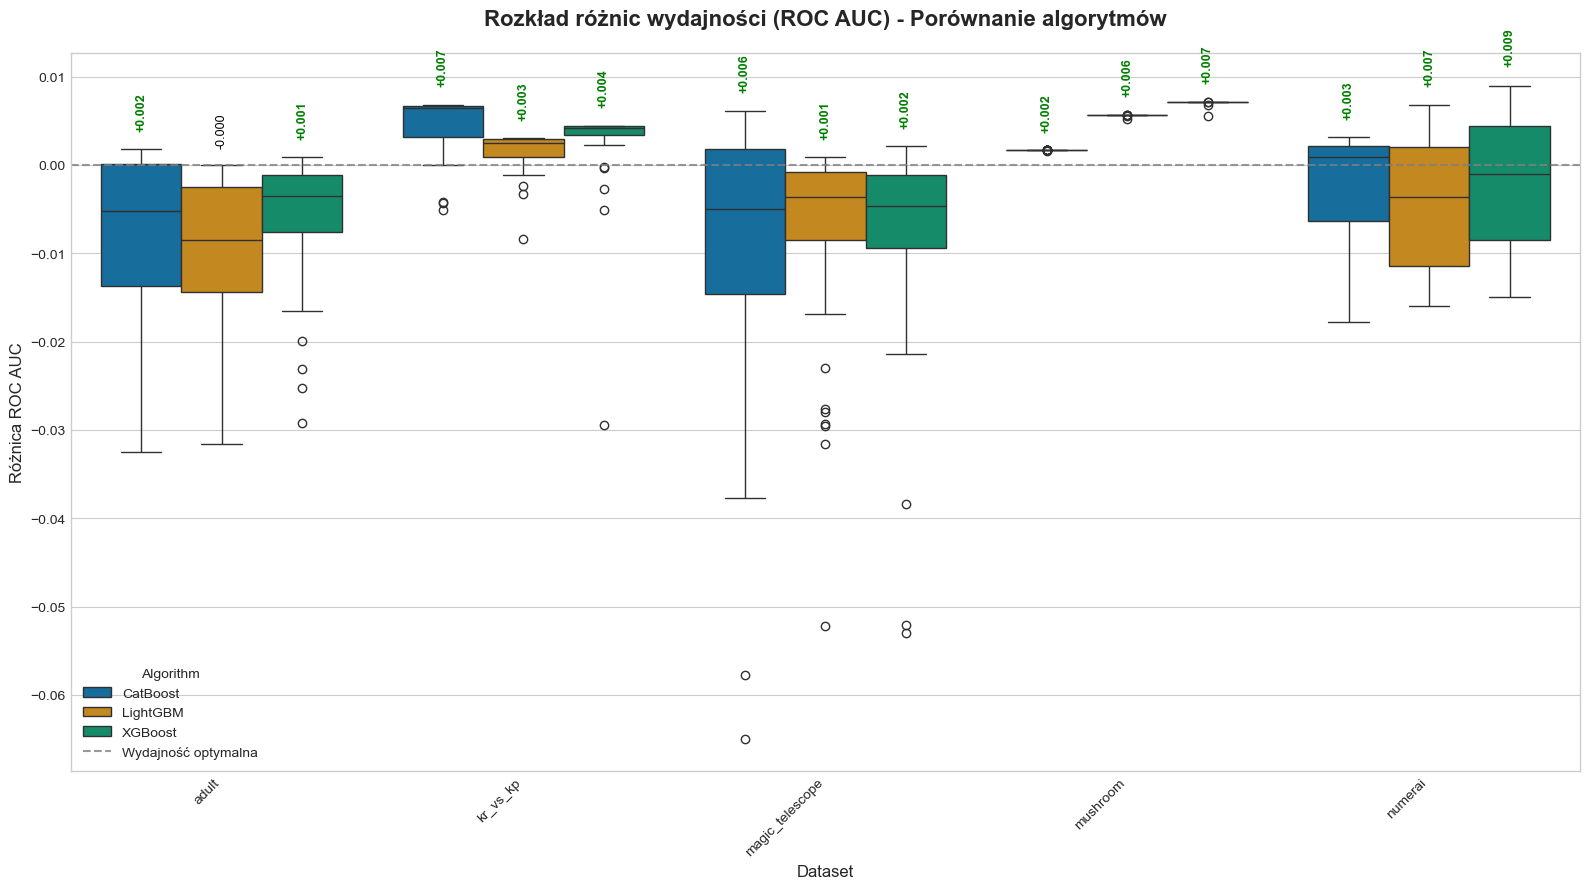

In [56]:
create_grouped_boxplots_annotated(
    df_plot=df_all_algos_bayes,
    dataset_column='dataset',
    algorithm_column='algorithm',
    y_column='performance_diff',
    title='Rozkład różnic wydajności (ROC AUC) - Porównanie algorytmów',
    y_label=f'Różnica ROC AUC'
)